# Build a Clang

In [1]:
import sqlalchemy as sql
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import datetime
import humanize

from collections import OrderedDict
from matplotlib.ticker import FuncFormatter
from collections import OrderedDict
from labm8 import fs, viz

def cache_time(path):
    modified = datetime.datetime.fromtimestamp(os.path.getmtime(path))
    diff = datetime.datetime.now() - modified
    return humanize.naturaltime(diff) + " ({})".format(modified)

%matplotlib inline
sns.set(style="ticks", color_codes=True)
plt.style.use(["seaborn-white", "seaborn-paper"])

import db
from db import *
%run util.py

NUM_PROGRAMS = 75000

hostname = "cc1"
db.init(hostname)

'mysql://cc1:3306/project_b'

In [41]:
def get_crash_ratio_table():
    rows = []
    with Session(commit=False) as s:
        clangs = s.query(CLgenClangResult.clang)\
                    .distinct()\
                    .order_by(CLgenClangResult.clang)

        for clang, in clangs:
            # results for this clang
            q = s.query(CLgenClangResult.id)\
                .filter(CLgenClangResult.clang == clang)\
                .order_by(CLgenClangResult.program_id)

            num_crashes = q.filter(CLgenClangResult.status != 0,
                                   CLgenClangResult.status != 1)\
                            .limit(NUM_PROGRAMS).count()
            num_programs = q.limit(NUM_PROGRAMS).count()
            
            assertions = s.query(CLgenClangAssertion.id)\
                .join(CLgenClangStderr)\
                .join(CLgenClangResult)\
                .filter(CLgenClangResult.clang == clang)\
                .distinct()\
                .count()
                
            unreachables = s.query(CLgenClangUnreachable.id)\
                .join(CLgenClangStderr)\
                .join(CLgenClangResult)\
                .filter(CLgenClangResult.clang == clang)\
                .distinct()\
                .count()
                
            terminate = s.query(CLgenClangTerminate.id)\
                .join(CLgenClangStderr)\
                .join(CLgenClangResult)\
                .filter(CLgenClangResult.clang == clang)\
                .distinct()\
                .count()

            ratio = num_crashes / num_programs
            rows.append([clang, num_programs, num_crashes, ratio, assertions, unreachables, terminates])
    return pd.DataFrame(rows, columns=["Version", "#. Results", "#. Crashes", "Ratio", "#. Assertions"])

ratio_table = get_crash_ratio_table()
ratio_table

,Version,#. Results,#. Crashes,Ratio,#. Assertions
0,3.4.2,25000,0,0.000000,0
1,3.5.2,75000,176,0.002347,2
2,3.6.2,75000,3196,0.042613,3
3,3.7.1,75000,1370,0.018267,2
4,3.8.1,75000,1347,0.017960,2
5,3.9.1,75000,429,0.005720,2
6,4.0.1,75000,542,0.007227,2
7,5.0.0,75000,96,0.001280,1
8,6.0.0,75000,121,0.001613,3


/home/cec/src/project_b/env/python3.6/lib/python3.6/site-packages/matplotlib/scale.py:101: RuntimeWarning: invalid value encountered in less_equal
  a[a <= 0.0] = 1e-300


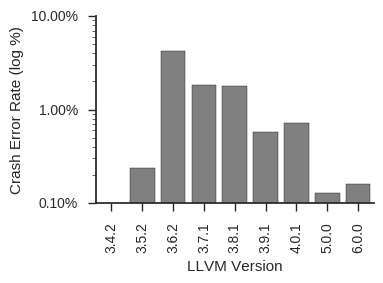

Current branch master is up to date.
[INFO  ] Wrote /home/cec/docs/paper-project_b/build/img/clang-crashes.pdf
[master fe5bd5d] auto: build/img/clang-crashes.pdf
 1 file changed, 0 insertions(+), 0 deletions(-)
Counting objects: 5, done.
Delta compression using up to 16 threads.
Compressing objects: 100% (5/5), done.
Writing objects: 100% (5/5), 444 bytes | 0 bytes/s, done.
Total 5 (delta 3), reused 0 (delta 0)
remote: Resolving deltas: 100% (3/3)
remote: Updating references: 100% (1/1)
To https://git.overleaf.com/8608915dsywxshwwjmw
   b086803..fe5bd5d  master -> master


In [37]:
sns.set(style="ticks")

def plot_crash_rate(*args, **kwargs):
    ax = sns.barplot(x="Version", y='Ratio', data=ratio_table, color='gray')

    # X axis
    plt.xlabel("LLVM Version")
    plt.setp(ax.get_xticklabels(), rotation=90)  # rotate x ticks

    # Y axis
    plt.ylabel("Crash Error Rate (log %)")
    ax.set_yscale("log", nonposy='clip')
    ax.set_yticklabels(['{:3.2f}%'.format(x*100) for x in ax.get_yticks()])
    # plt.ylim((0,None))
    
    # Border
    sns.despine(ax=ax)
    
    viz.finalise(*args, **kwargs)

plot_crash_rate(figsize=(4, 3))

# push LaTex to Overleaf
!cd ~/docs/paper-project_b/ && git pull --rebase
plot_crash_rate(fs.path("~/docs/paper-project_b/build/img/clang-crashes.pdf"), figsize=(4, 3))
!cd ~/docs/paper-project_b/build && git add . && git commit -m "auto: build/img/clang-crashes.pdf" && git push